Setting up sagemaker env

In [3]:
# installing packages
import boto3
import pandas as pd
import numpy as np
import sagemaker

In [4]:
print(f"using sagemaker version: {sagemaker.__version__} ")

using sagemaker version: 2.68.0 


In [5]:
# import execution roles
role = sagemaker.get_execution_role()

# region, bucket and other necessities
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
s3_client = boto3.client('s3', region_name=region)
sagemaker_client = boto3.client('sagemaker-runtime')
default_bucket = sagemaker_session.default_bucket()

prefix = 'sagemaker-pipelines-with-blazingtext-nlp'

### obtain training data

In [6]:
!mkdir -p data

In [7]:
!wget https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/womens_clothing_ecommerce/Womens_Clothing_E-Commerce_Reviews.csv -O 'data/Womens Clothing E-Commerce Reviews.csv'

--2021-12-08 05:14:25--  https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/womens_clothing_ecommerce/Womens_Clothing_E-Commerce_Reviews.csv
Resolving sagemaker-sample-files.s3.amazonaws.com (sagemaker-sample-files.s3.amazonaws.com)... 52.217.78.220
Connecting to sagemaker-sample-files.s3.amazonaws.com (sagemaker-sample-files.s3.amazonaws.com)|52.217.78.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8483448 (8.1M) [text/csv]
Saving to: ‘data/Womens Clothing E-Commerce Reviews.csv’

data/Womens Clothin 100%[===================>]   8.09M  49.6MB/s    in 0.2s    

2021-12-08 05:14:25 (49.6 MB/s) - ‘data/Womens Clothing E-Commerce Reviews.csv’ saved [8483448/8483448]



In [8]:
df = pd.read_csv('data/Womens Clothing E-Commerce Reviews.csv', index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


checking for imbalance in dataset.....


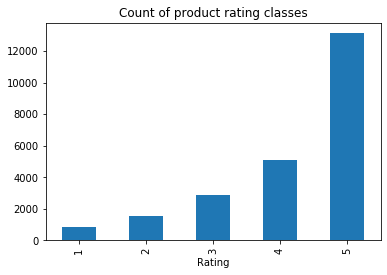

In [9]:
print('checking for imbalance in dataset.....')
plot = df.groupby('Rating')['Rating'].count().plot(kind='bar', title='Count of product rating classes')

looking above the plot, it seems that the dataset contains lot of datapoints for class 5, while contains lesser points for the other review classes.

In [10]:
# upload data to s3 bucket
local_path = "data/Womens Clothing E-Commerce Reviews.csv"

base_uri = f"s3://{default_bucket}/{prefix}/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
                    local_path=local_path,
                    desired_s3_uri=base_uri,
)

print(f"input data path to s3 bucket: {input_data_uri}")

input data path to s3 bucket: s3://sagemaker-us-east-1-908912589397/sagemaker-pipelines-with-blazingtext-nlp/data/Womens Clothing E-Commerce Reviews.csv


## Define parameters to parametrize pipeline execution

benefits of using sagemaker pipelines, is that we can override and change the pipeline using these parameters anytime, without having to create a new pipeline.

In [11]:
from sagemaker.workflow.parameters import (ParameterInteger, ParameterString)

# location of input data
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)

# default num of instances for processing step
processing_instance_count = ParameterInteger(
    name="ProcessingInputCount",
    default_value=1
)

# default instance type for processing step
processing_instance_type = ParameterString(
    name="ProcessingInstanceType",
    default_value="ml.m4.xlarge"
)

# defautl instance type for training
train_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.m4.xlarge",
)

# default model approval mode
model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="Approved"
)

## Create Dataset and perform train-test split

In [14]:
!mkdir -p code

In [15]:
%%writefile code/preprocessing.py

import numpy as np
import pandas as pd
import string
from sklearn.utils import resample


base_dir = "/opt/ml/processing"

df = pd.read_csv(f"{base_dir}/input/Womens Clothing E-Commerce Reviews.csv")
df = df[df['Review Text'].notna()]  # drop rows without review text


def process_review(text):
    punctuation = string.punctuation
    review = text.lower()
    review = review.replace("\r\n", " ").replace("\n\n", " ")  # clean text of \r, \n and \n\n with whie space
    translator = str.maketrans("", "", punctuation)
    review = review.translate(translator)
    return review


# create columns to concatenate reviews and new labels
df['Complete_Review'] = df["Title"] + " " + df['Review Text']
df = df[df['Complete_Review'].notna()]  # drop rows with NA
# ratings 1 & 2 are mapped to negative reviews
# rating 3 & 4 are mapped to neutral
# rating 5 is mapped as positive
df['Label'] = df['Rating'].map({1:"negative", 2:"negative", 3:"none", 4:"none", 5:"positive"})
df = df.loc[df['Label'].isin(['negative', 'positive'])]  # using only neg and pos reviews
df['Review'] = df['Complete_Review'].astype(str).apply(process_review)  # applying process_review() on each review text
df['Processed'] = '__label__' + df['Label'].astype(str) + ' ' + df['Review']


# create train--test split
train, validation, test = np.split(df, [int(0.7 * len(df)), int(0.85 * len(df))])

# performing oversampling to deal with imbalance in dataset
positive = train.loc[train['Label']=='positive']
negative = train.loc[train['Label']=='negative']

# oversampling the minority classes
negative_oversample = resample(negative, replace=True, n_samples=len(positive))

# remake training sample 
train = pd.concat([positive, negative_oversample])

# create series dataset for Blazing Text input format
train = train['Processed']
validation = validation['Processed']
test = test['Processed']


# save datasets 
pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"{base_dir}/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

print(f"Number of reviews in the training dataset: {train.shape[0]}")
print(f"Number of reviews in the validation set: {validation.shape[0]}")

Overwriting code/preprocessing.py


In [16]:
from sagemaker.sklearn.processing import SKLearnProcessor

framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count, 
    base_job_name="sklearn-nlp-process",
    role=role,
)

In [17]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep


s3_client.upload_file(Filename='./code/preprocessing.py', Bucket=default_bucket, Key=f'{prefix}/code/preprocessing.py')
preprocess_script_uri = f's3://{default_bucket}/{prefix}/code/preprocessing.py'

process_step = ProcessingStep(
    name="BTDemoProcessStep",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/op/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code=preprocess_script_uri,
)

## Train text classifier using BlazingText

In [42]:
# set up estimator

from sagemaker.estimator import Estimator


bt_estimator = Estimator(
    role=role,
    instance_type=train_instance_type,
    instance_count=1,
    image_uri=sagemaker.image_uris.retrieve("blazingtext", region),
    output_path=f's3://{default_bucket}/{prefix}/training_jobs',
    base_job_name='bt-model-estimator',
    input_mode='File')

# set up hyperparameters for blazing text model
bt_estimator.set_hyperparameters(mode='supervised',
                                epochs=25,
                                learning_rate=0.02,
                                min_count=2,
                                early_stopping=True,
                                patience=4,
                                min_epochs=10,
                                word_ngrmas=3
                                )

In [43]:
# set up model training step

from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

train_step = TrainingStep(
    name='BTDemoTrainStep',
    estimator=bt_estimator,
    inputs={
        'train': TrainingInput(
            s3_data=process_step.properties.ProcessingOutputConfig.Outputs['train'].S3Output.S3Uri,
            content_type='text/csv'
        ),
    'validation': TrainingInput(
        s3_data=process_step.properties.ProcessingOutputConfig.Outputs['test'].S3Output.S3Uri,
        content_type='text/csv'
    )
    }
)

## Model Creation

In [44]:
from sagemaker.workflow.steps import CreateModelStep


model = sagemaker.model.Model(
    name='nlp-blazingtext-model',
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role
)

In [45]:
inputs = sagemaker.inputs.CreateModelInput(
    instance_type='ml.m4.xlarge'
)

create_model_step = CreateModelStep(
    name='BTDemoCreatemodelStep',
    model=model,
    inputs=inputs
)

## model deployment 

In [26]:
%%writefile code/deploy_model.py

import time
from datetime import datetime
import boto3
import argparse


# parse argument variables passed via the Deploy model processing step
parser = argparse.ArgumentParser()
parser.add_argument('--model-name', type=str)
parser.add_argument('--region', type=str)
parser.add_argument('--endpoint-instance-type', type=str)
parser.add_argument('--endpoint-name', type=str)
args = parser.parse_args()


region = args.region
boto3.setup_default_session(region_name=region)
sagemaker_boto_client = boto3.client('sagemaker')


# define endpoint configuration
endpoint_config_name = f'{args.endpoint_name}-config-{datetime.now().strftime("%Y%m%d-%H%M%S")}'


# create new endpoint config file
create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': args.endpoint_instance_type,
        'InitialVariantWeight': 1,
        'InitialInstanceCount': 1,
        'ModelName': args.model_name,
        'VariantName': 'AllTrafic'
    }]    
)

print(f"ModelName: {args.model_name}")

# create endpoint if model endpoint doesnot exist, or update the endpoint
try:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=endpoint_config_name
    )
except:
      create_endpoint_response = sagemaker_boto_client.update_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=endpoint_config_name
    )
        

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
endpoint_status = endpoint_info['EndpointStatus']


while endpoint_status != 'InService':
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
    endpoint_status = endpoint_info['EndpointStatus']
    
    print(f'Endpoint status: {endpoint_status}')
    if endpoint_status != 'InService':
        time.sleep(30)

Writing code/deploy_model.py


In [46]:
s3_client.upload_file(Filename='./code/deploy_model.py', Bucket=default_bucket, Key=f'{prefix}/code/deploy_model.py')
deploy_model_script_uri = f's3://{default_bucket}/{prefix}/code/deploy_model.py'
pipeline_endpoint_name = 'nlp-blazingtext-model-endpoint'

deployment_instance_type = 'ml.m4.xlarge'

deploy_model_processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    volume_size_in_gb=60,
    base_job_name='nlp-blazingtext-deploy-model',
    sagemaker_session=sagemaker_session
)

deploy_step = ProcessingStep(
    name='BTDemoDeployStep',
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name", create_model_step.properties.ModelName, 
        "--region", region, 
        "--endpoint-instance-type", deployment_instance_type,
        "--endpoint-name", pipeline_endpoint_name
    ],
    code=deploy_model_script_uri
)

## Register model

In [47]:
from sagemaker.workflow.step_collections import RegisterModel

register_step = RegisterModel(
    name="BTDemoRegistermodelStep",
    estimator=bt_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=['text/csv'],
    response_types=['text.csv'],
    inference_instances=['ml.t3.medium', 'ml.m5.xlarge'],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=prefix,
    approval_status=model_approval_status
)

## Create pipeline

In [48]:
from sagemaker.workflow.pipeline import Pipeline

# run full pipeline
steps_full = [process_step,
             train_step,
             create_model_step,
             deploy_step,
             register_step]

# run data processing step
step_preprocessing = [process_step]

pipeline_name = "BlazingTextPipeline"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        train_instance_type,
        model_approval_status,
        input_data
    ],
    steps=steps_full
)

In [32]:
import json

definition = json.loads(pipeline.definition())
print(definition)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'Version': '2020-12-01', 'Metadata': {}, 'Parameters': [{'Name': 'ProcessingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m4.xlarge'}, {'Name': 'ProcessingInputCount', 'Type': 'Integer', 'DefaultValue': 1}, {'Name': 'TrainingInstanceType', 'Type': 'String', 'DefaultValue': 'ml.m4.xlarge'}, {'Name': 'ModelApprovalStatus', 'Type': 'String', 'DefaultValue': 'Approved'}, {'Name': 'InputData', 'Type': 'String', 'DefaultValue': 's3://sagemaker-us-east-1-908912589397/sagemaker-pipelines-with-blazingtext-nlp/data/Womens Clothing E-Commerce Reviews.csv'}], 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'}, 'TrialName': {'Get': 'Execution.PipelineExecutionId'}}, 'Steps': [{'Name': 'BTDemoProcessStep', 'Type': 'Processing', 'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': {'Get': 'Parameters.ProcessingInstanceType'}, 'InstanceCount': {'Get': 'Parameters.ProcessingInputCount'}, 'VolumeSizeInGB': 30}}, 'AppSpecification': {'ImageUri': '6

In [33]:
pipeline.upsert(role_arn=role)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:908912589397:pipeline/blazingtextpipelineforwomensfashion',
 'ResponseMetadata': {'RequestId': '6a68abb2-63a8-48e5-83b3-042b6d6afda6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6a68abb2-63a8-48e5-83b3-042b6d6afda6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '103',
   'date': 'Wed, 08 Dec 2021 07:54:58 GMT'},
  'RetryAttempts': 0}}

In [49]:
execution = pipeline.start()

ValueError: This pipeline is not associated with a Pipeline in SageMaker. Please invoke create() first before attempting to invoke start().

In [50]:
print(f"describe execution of pipeline:\n {execution.describe()}")

describe execution of pipeline:
 {'PipelineArn': 'arn:aws:sagemaker:us-east-1:908912589397:pipeline/blazingtextpipelineforwomensfashion', 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:908912589397:pipeline/blazingtextpipelineforwomensfashion/execution/4eg4tn2rkqjd', 'PipelineExecutionDisplayName': 'execution-1638950212292', 'PipelineExecutionStatus': 'Failed', 'PipelineExperimentConfig': {'ExperimentName': 'blazingtextpipelineforwomensfashion', 'TrialName': '4eg4tn2rkqjd'}, 'FailureReason': 'Step failure: One or multiple steps failed.', 'CreationTime': datetime.datetime(2021, 12, 8, 7, 56, 52, 169000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2021, 12, 8, 7, 56, 55, 429000, tzinfo=tzlocal()), 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:908912589397:user-profile/d-vvhqfw29pcnt/sagemaker-sh', 'UserProfileName': 'sagemaker-sh', 'DomainId': 'd-vvhqfw29pcnt'}, 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:908912589397:user-profile/d

In [51]:
execution.wait()
print(f"list execution list and their status\n {execution.list_steps}")

WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression "PipelineExecutionStatus" we matched expected path: "Failed"

### use deployed model to return predictions

In [35]:
import string

def process_review(text):
    punctuation = string.punctuation
    review = text.lower()
    review = review.replace("\r\n", " ").replace("\n\n", " ")
    translator = str.maketrans("","", punctuation)
    review = review.translate(translator)
    return review

In [36]:
sentences = ["i loved this blouse when i saw it on-line, and the fabric is so soft!",
             "love the top, but very small to the size. ordered a medium and had to send back in exchange for x-large",
             "horrible! this top was scratchy and too small."]
# process the reviews to predict the same as training data
processed_sentences = [ process_review(sent) for sent in sentences ]

payload = {"instances" : processed_sentences}

In [37]:
def get_predictions(payload, endpoint_name, client):
    response = client.invoke_endpoint(EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType='application/json')
    predictions = json.loads(response['Body'].read().decode('utf-8'))
    return list(zip(payload['instances'], predictions))

In [38]:
# return predictions
get_predictions(payload, pipeline_endpoint_name, sagemaker_client)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint nlp-blazingtext-model-endpoint of account 908912589397 not found.